In [148]:
import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

crit_thresh = -0.094870
warn_thresh = -0.042534

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler.joblib')
iso_model = load('./model/iso_model.joblib')

# Load datasets
df1 = pd.read_csv("./data/dev101_resample1T_validate.csv")
df2 = pd.read_csv("./data/dev102_resample1T_validate.csv")
df_val = pd.concat([df1, df2], ignore_index=True)
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [149]:
df_val['label'] = df_val['label'].fillna('Normal')
df_val

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,label
0,5/2/2025 11:42,101,28.839999,0.0,34.233463,63.098955,14.622758,Normal
1,5/2/2025 11:42,102,22.200001,0.0,34.478334,61.378755,8.284870,Normal
2,5/2/2025 11:43,102,22.200001,0.0,34.318556,62.127083,6.897215,Normal
3,5/2/2025 11:43,101,28.816666,0.0,34.047519,63.319192,10.538904,Normal
4,5/2/2025 11:44,102,22.200001,0.0,34.319447,62.117800,6.202946,Normal
...,...,...,...,...,...,...,...,...
4303,5/3/2025 9:57,102,52.583332,0.0,36.739656,58.319639,7.333853,Normal
4304,5/3/2025 9:58,101,48.966667,0.0,34.285177,64.789782,10.940889,Normal
4305,5/3/2025 9:58,102,52.599998,0.0,37.316089,58.870299,5.382545,Normal
4306,5/3/2025 9:59,102,52.599998,0.0,37.511826,55.926516,3.426730,Normal


In [150]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,101.500232,41.242397,1.303179,30.161941,75.867146,8.266270
std,0.500058,13.173533,4.971532,3.035887,7.180291,4.445105
min,101.000000,21.100000,0.000000,25.568246,54.778273,1.860340
25%,101.000000,27.400000,0.000000,27.425628,68.814601,3.914455
50%,102.000000,47.000000,0.000000,29.109903,80.257725,7.473666
75%,102.000000,52.500000,0.000000,33.356359,81.290190,11.014947
max,102.000000,57.650001,40.513000,37.511826,86.655329,26.214587


In [151]:
print(df_val['label'].value_counts())

label
Normal      3381
critical     712
warning      215
Name: count, dtype: int64


## Threshold

In [152]:
# สร้าง features
feature_cols = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
crit_thresh = -0.094870
warn_thresh = -0.042534

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)
print("Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.")

print("\nPredicted Risk Distribution:")
print(df_val['predicted_risk'].value_counts())

print("\nLabel Distribution:")
print(df_val['label'].value_counts())

#print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.4))
#print("warn_thresh:", np.percentile(df_val['anomaly_score'], 1))

Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.

Predicted Risk Distribution:
predicted_risk
Normal      4082
Critical     119
Warning      107
Name: count, dtype: int64

Label Distribution:
label
Normal      3381
critical     712
warning      215
Name: count, dtype: int64


In [153]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
        soil_mean   rain_mean   temp_mean   humi_mean    geo_mean
count  119.000000  119.000000  119.000000  119.000000  119.000000
mean    50.582199   25.527260   26.558510   81.123104   14.586196
std      8.030187    8.103925    0.586014    0.659040    6.814688
min     22.640001   11.287760   25.568246   80.136035    3.906746
25%     51.690000   15.925800   26.072360   80.614406    6.409211
50%     53.339999   25.704800   26.284961   80.982149   17.187568
75%     54.200001   34.086800   27.109827   81.718015   19.328118
max     55.719999   40.513000   27.737087   82.877702   26.214587


In [154]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
        soil_mean   rain_mean   temp_mean   humi_mean    geo_mean
count  107.000000  107.000000  107.000000  107.000000  107.000000
mean    48.121153   13.785779   27.007240   81.154950   11.958405
std     11.889546    4.507702    0.620698    0.721070    5.858938
min     21.600000    2.654300   25.710975   80.166934    2.610579
25%     45.520000   11.176000   26.682218   80.683261    5.456645
50%     53.299999   12.852400   26.957885   80.952106   13.341291
75%     55.530000   15.925800   27.372054   81.744592   16.622999
max     57.500000   25.425400   28.440987   84.878448   24.401495


In [155]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
         soil_mean    rain_mean    temp_mean    humi_mean     geo_mean
count  4082.000000  4082.000000  4082.000000  4082.000000  4082.000000
mean     40.789810     0.269788    30.349682    75.575315     7.985249
std      13.176763     1.180553     3.005372     7.263733     4.125252
min      21.100000     0.000000    25.753033    54.778273     1.860340
25%      27.400000     0.000000    27.530038    68.231992     3.913877
50%      46.658333     0.000000    29.364342    79.792516     7.421424
75%      52.400002     0.000000    33.467278    81.278413    10.655167
max      57.650001    11.734800    37.511826    86.655329    23.619679


C:\Users\ahmad\AppData\Local\Temp\ipykernel_19024\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


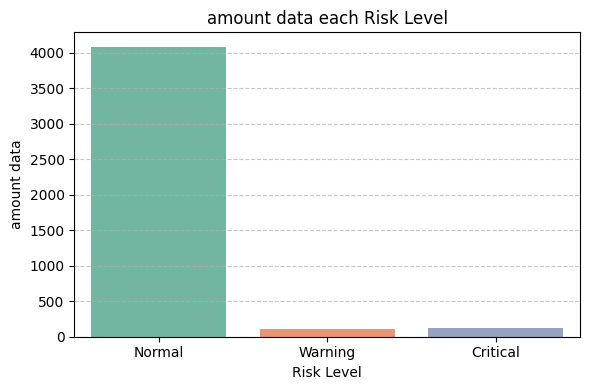

In [156]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

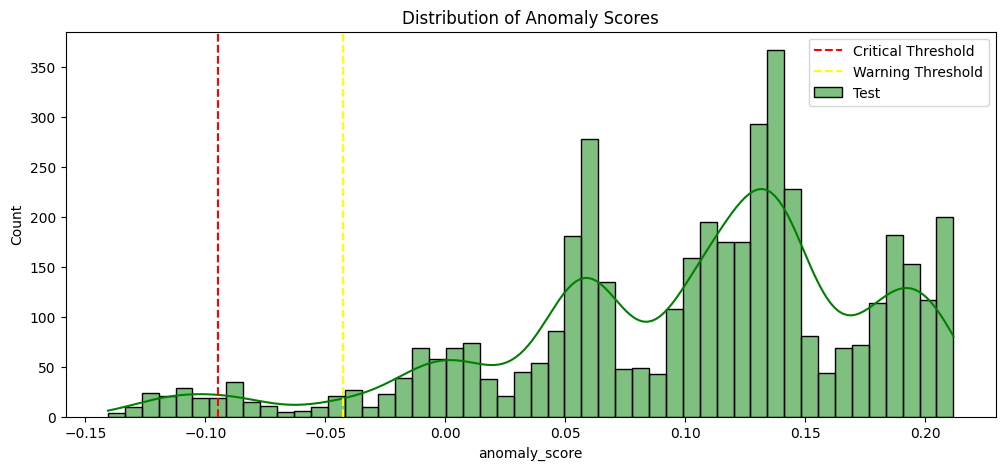

In [157]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()

## PCA

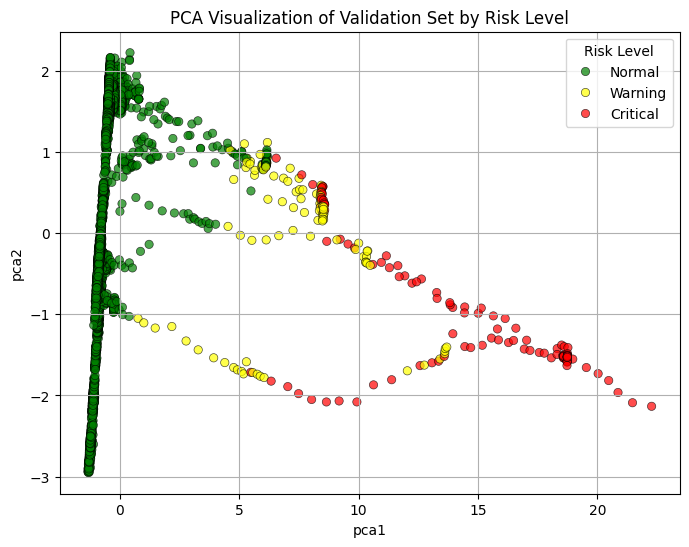

In [158]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [159]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                soil_mean  rain_mean  temp_mean  humi_mean   geo_mean
predicted_risk                                                       
Critical        50.582199  25.527260  26.558510  81.123104  14.586196
Normal          40.789810   0.269788  30.349682  75.575315   7.985249
Warning         48.121153  13.785779  27.007240  81.154950  11.958405


In [160]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      4082
Critical     119
Warning      107
Name: count, dtype: int64


## histogram

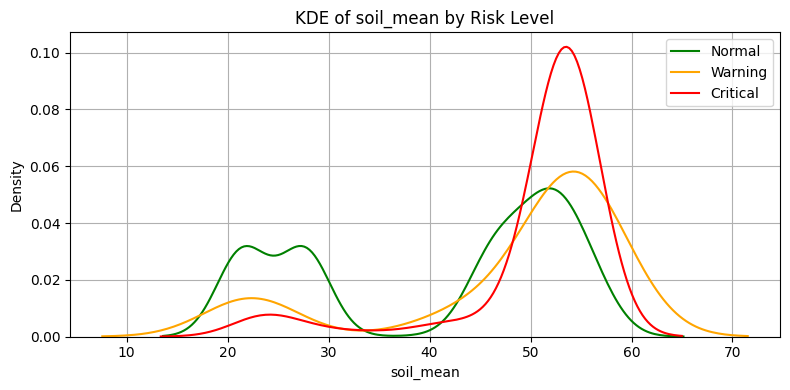

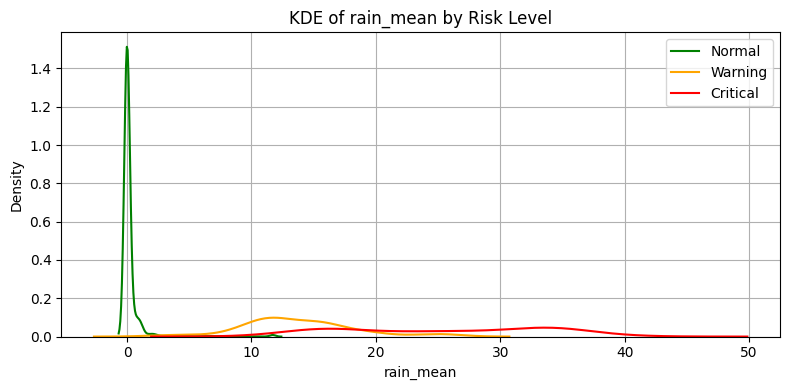

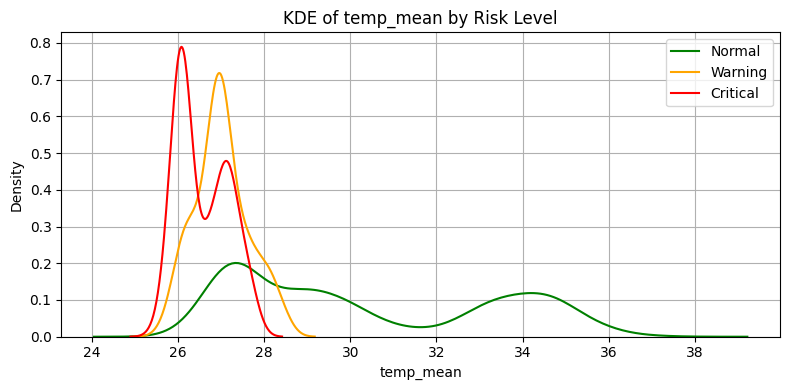

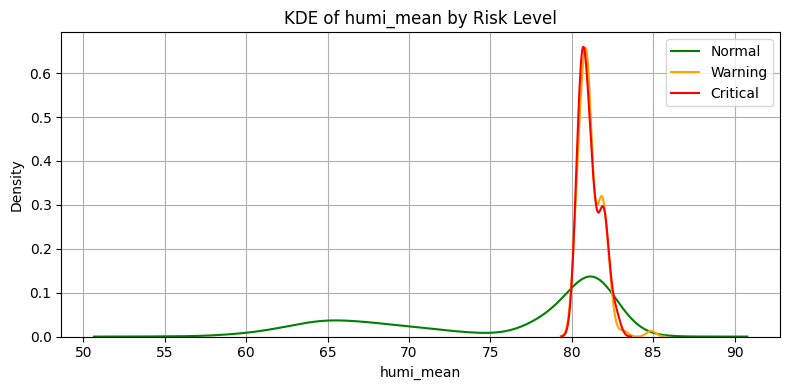

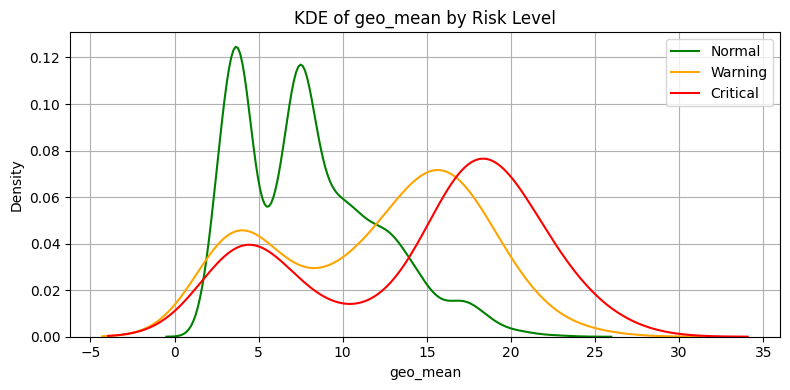

In [161]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_19024\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_19024\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_19024\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_19024\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

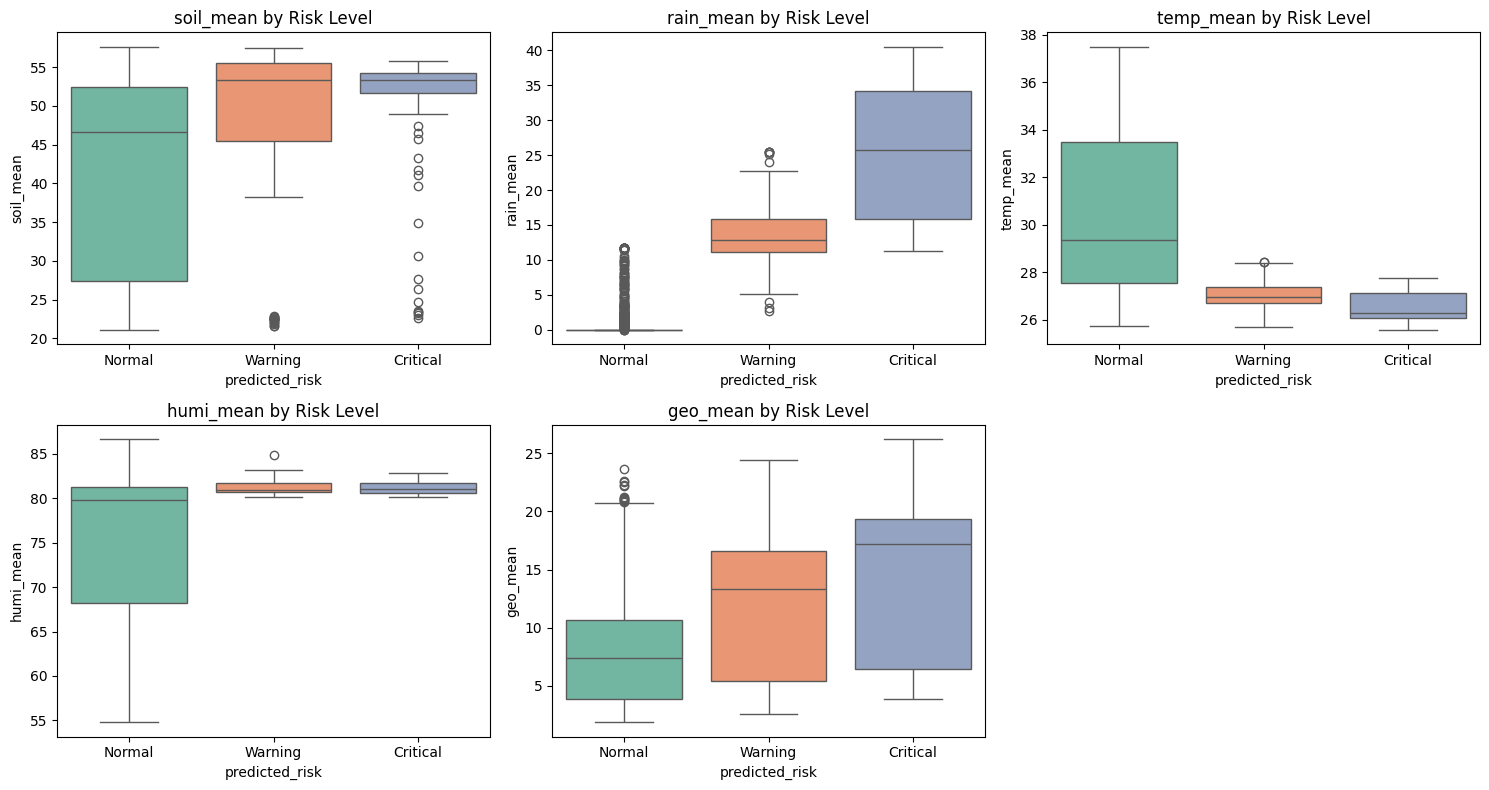

In [162]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [163]:
df_val['timestamp'].min()

'5/2/2025 11:42'

In [164]:
df_val['timestamp'].max()

'5/3/2025 9:59'

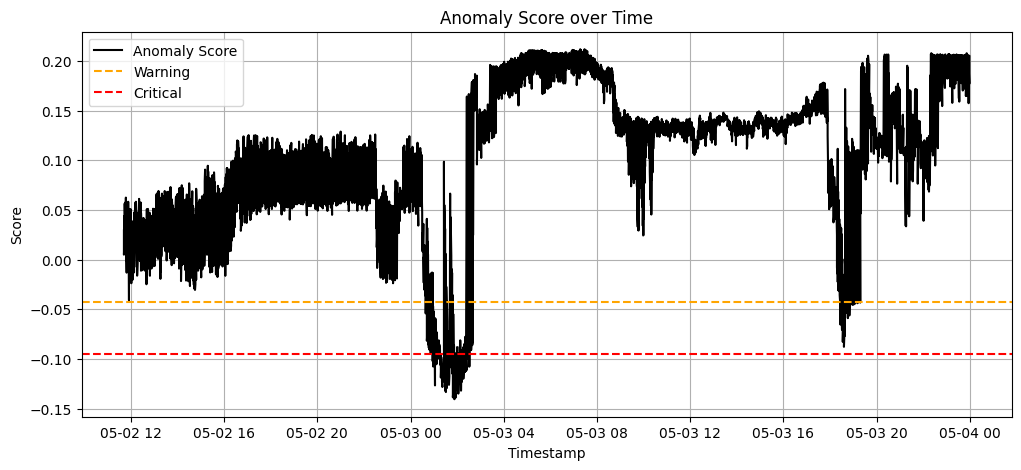

In [165]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

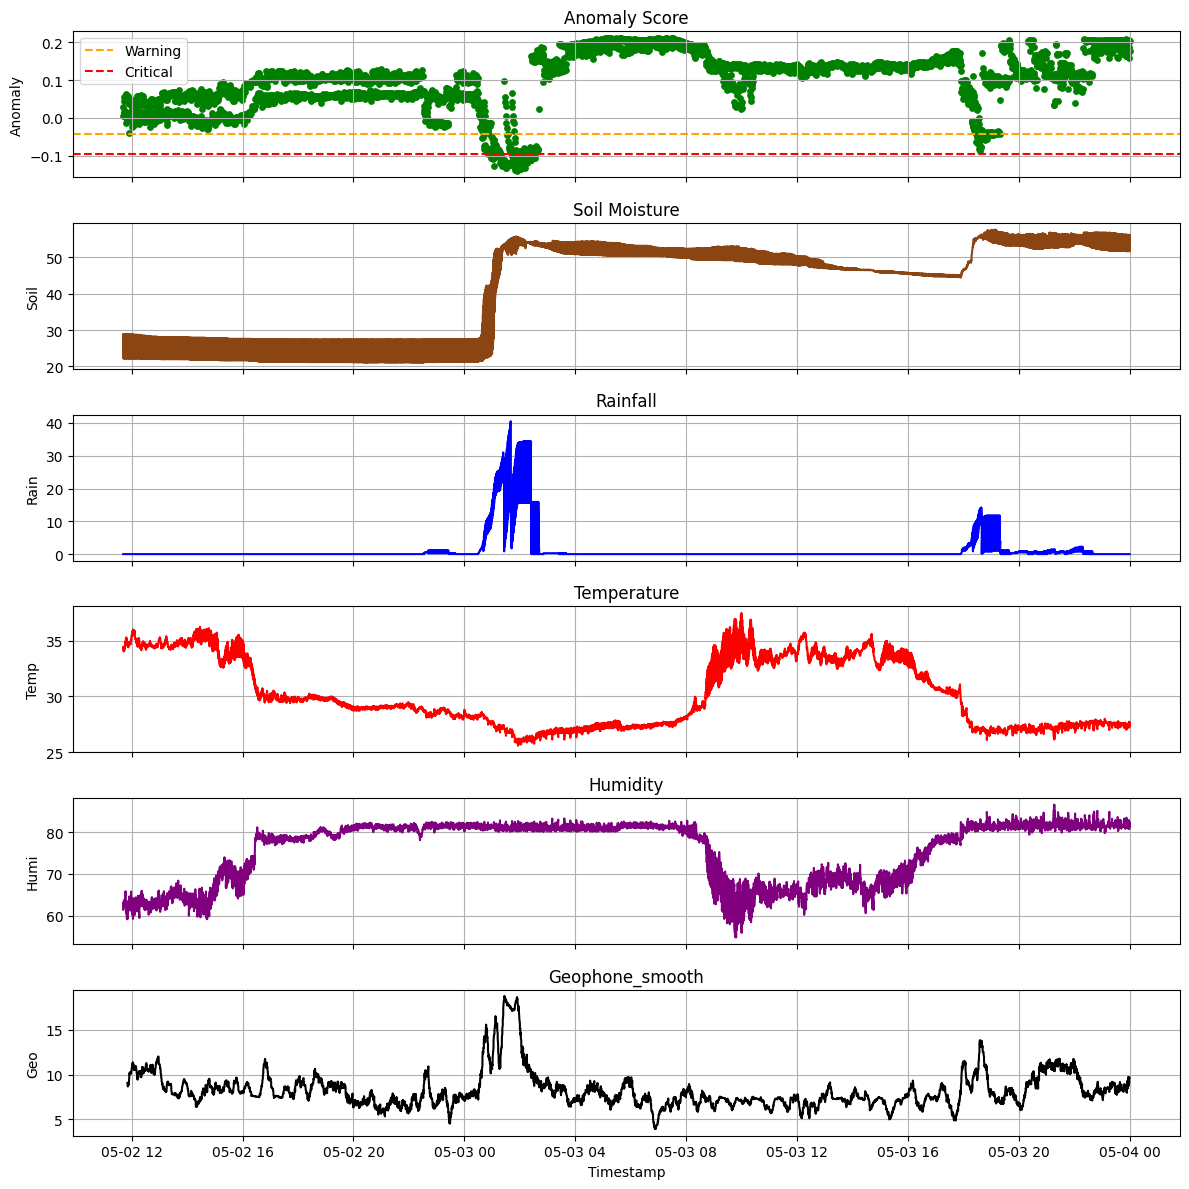

In [166]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_range = df_dev.loc["2025-05-2":"2025-05-4"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil_mean'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain_mean'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp_mean'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi_mean'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo_mean'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone_smooth")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


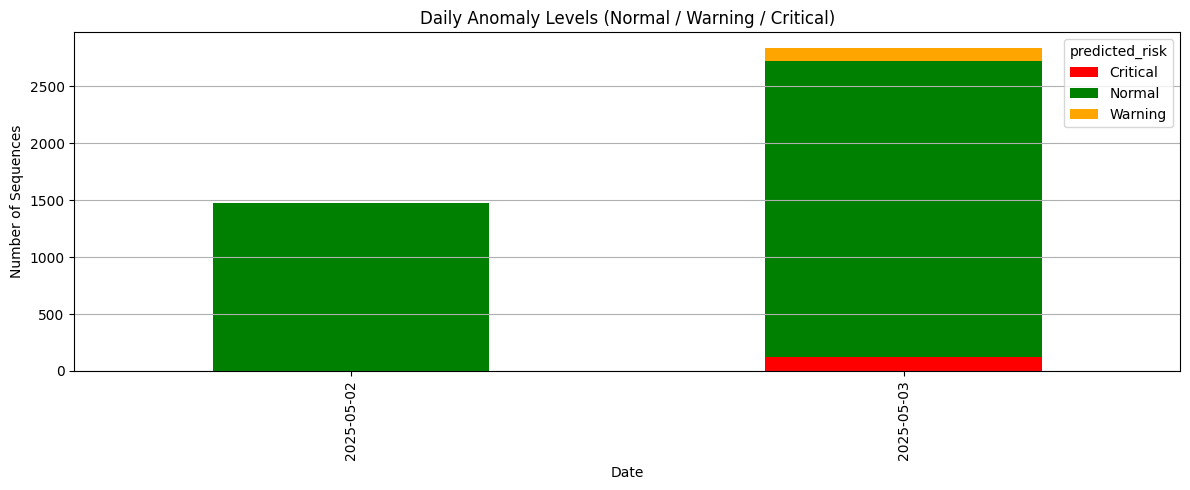

In [170]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


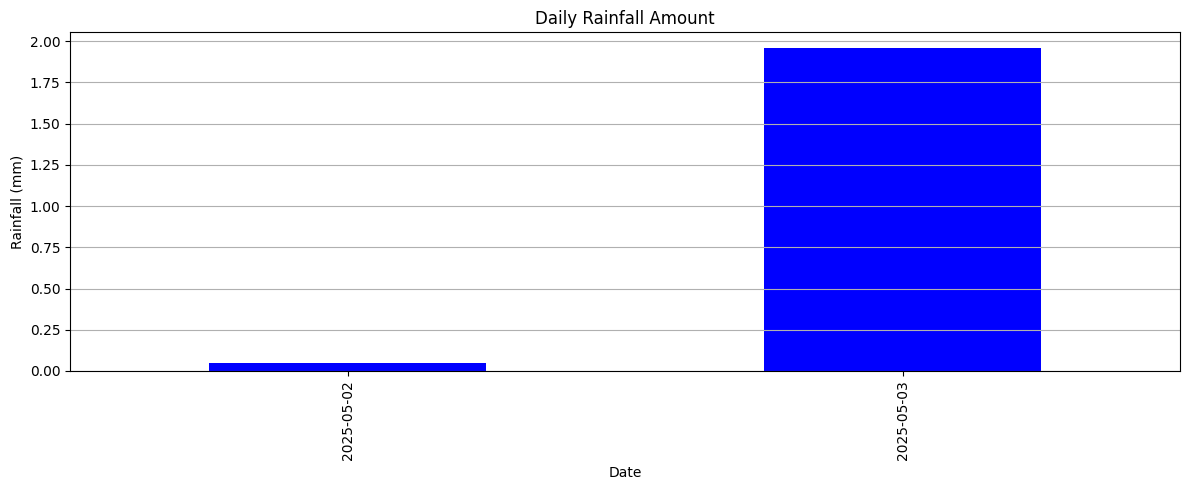

In [ ]:
# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain_mean'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# F1-score

In [167]:

# --- 4. Prepare True Labels for Multi-Class Evaluation ---

df_val['true_label_mapped_multi'] = df_val['label'].replace({
    'critical': 'Critical', 
    'normal': 'Normal',
    'Normal': 'Normal',
    'warning':'Warning'
})

label_order = ['Critical', 'Warning', 'Normal']

df_val_filtered_multi_eval = df_val[df_val['true_label_mapped_multi'].isin(label_order)].copy()

y_true_multi = df_val_filtered_multi_eval['true_label_mapped_multi']
y_pred_multi = df_val_filtered_multi_eval['predicted_risk']

print("\nTrue Label Mapping for Multi-Class Evaluation:")
print(y_true_multi.value_counts())
print("\nPredicted Risk Label Distribution (for Multi-Class F1-score):")
print(y_pred_multi.value_counts())



True Label Mapping for Multi-Class Evaluation:
true_label_mapped_multi
Normal      3381
Critical     712
Warning      215
Name: count, dtype: int64

Predicted Risk Label Distribution (for Multi-Class F1-score):
predicted_risk
Normal      4082
Critical     119
Warning      107
Name: count, dtype: int64


In [168]:
# --- 5. Calculate and Print Multi-Class F1-score and other metrics ---
print("\n--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---")

# For multi-class F1-score, we usually use 'weighted' or 'macro' average
# 'weighted' accounts for class imbalance
# 'macro' treats all classes equally
# 'None' gives F1-score for each class separately
f1_weighted = f1_score(y_true_multi, y_pred_multi, average='weighted', labels=label_order, zero_division=0)
f1_macro = f1_score(y_true_multi, y_pred_multi, average='macro', labels=label_order, zero_division=0)
f1_per_class = f1_score(y_true_multi, y_pred_multi, average=None, labels=label_order, zero_division=0)

print(f"\nWeighted F1-score: {f1_weighted:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"F1-score per class ({label_order}): {f1_per_class}")


# Full classification report for multi-class
print("\nClassification Report (Multi-Class):")
# target_names should match the order of labels in y_true_multi and y_pred_multi
print(classification_report(y_true_multi, y_pred_multi, labels=label_order, target_names=label_order, zero_division=0))


# Confusion Matrix for multi-class
cm_multi = confusion_matrix(y_true_multi, y_pred_multi, labels=label_order)
print("\nConfusion Matrix (Multi-Class):")
print(cm_multi)



--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---

Weighted F1-score: 0.7584
Macro F1-score: 0.3975
F1-score per class (['Critical', 'Warning', 'Normal']): [0.28640193 0.         0.90606995]

Classification Report (Multi-Class):
              precision    recall  f1-score   support

    Critical       1.00      0.17      0.29       712
     Warning       0.00      0.00      0.00       215
      Normal       0.83      1.00      0.91      3381

    accuracy                           0.81      4308
   macro avg       0.61      0.39      0.40      4308
weighted avg       0.82      0.81      0.76      4308


Confusion Matrix (Multi-Class):
[[ 119  107  486]
 [   0    0  215]
 [   0    0 3381]]


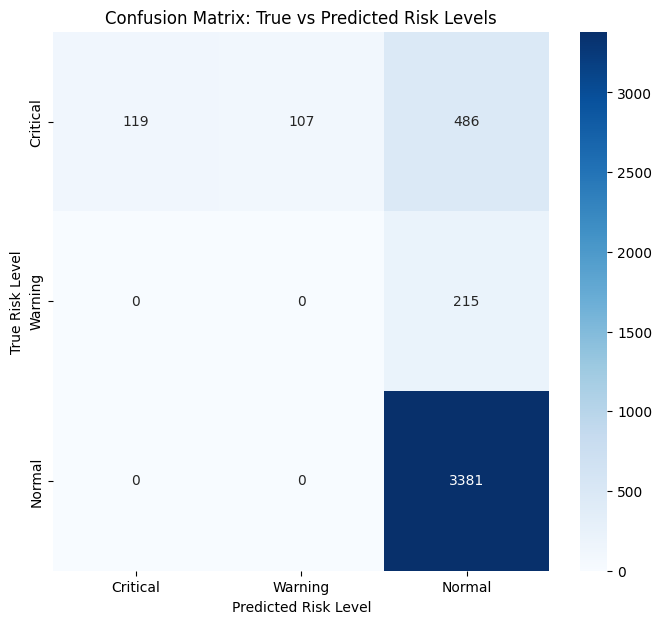

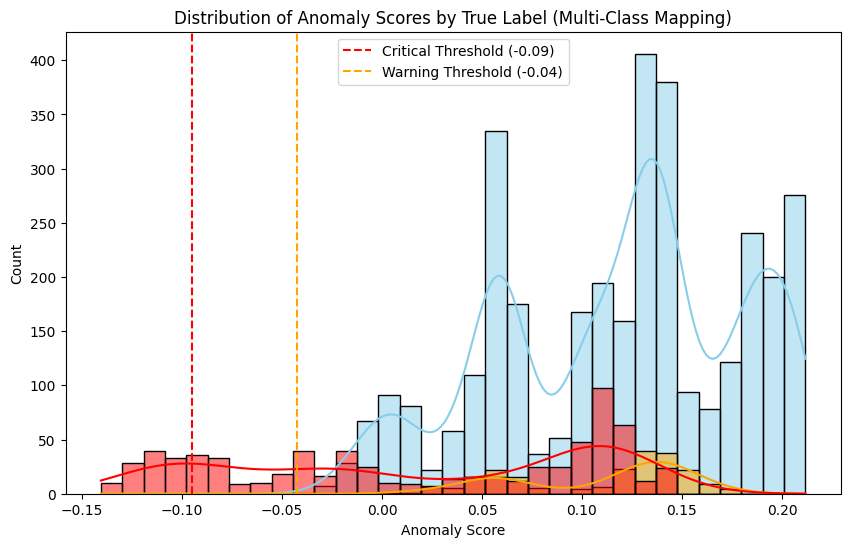

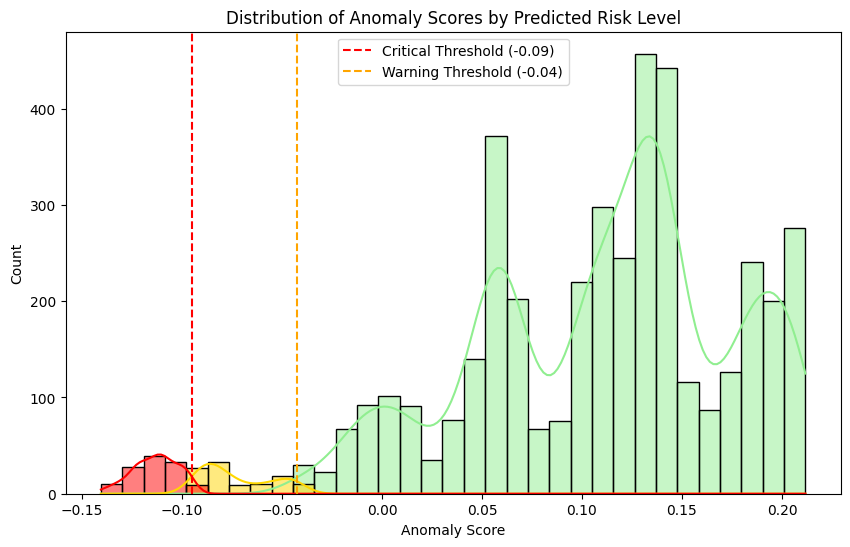

In [169]:
# Visualize Confusion Matrix for multi-class
plt.figure(figsize=(8, 7))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order)
plt.title('Confusion Matrix: True vs Predicted Risk Levels')
plt.xlabel('Predicted Risk Level')
plt.ylabel('True Risk Level')
plt.show()

# Visualize Anomaly Score Distribution by True Label (re-using previous plot logic)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='true_label_mapped_multi', kde=True,
             palette={'Normal': 'skyblue', 'Critical': 'red', 'Warning': 'orange'}, # Adjust palette for new labels
             hue_order=label_order) # Ensure consistent order
plt.title('Distribution of Anomaly Scores by True Label (Multi-Class Mapping)')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()

# Visualize Anomaly Score Distribution by Predicted Risk (already good)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='predicted_risk', kde=True,
             palette={'Normal': 'lightgreen', 'Warning': 'gold', 'Critical': 'red'},
             hue_order=label_order) # Use the same order for consistency
plt.title('Distribution of Anomaly Scores by Predicted Risk Level')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()